In [1]:
import os
import geopandas

import json
import topojson
from topojson.utils.ops import select_unique_combs
from topojson.utils.ops import junctions_shared_paths

from IPython.display import SVG, display
from shapely import geometry

import numpy as np
%matplotlib inline

In [2]:
def list_from_array(array_bk):
    """
    Function to convert numpy array to list, where elements set as np.nan 
    are filtered
    """

    list_bk = [obj[~np.isnan(obj)].tolist() for obj in array_bk]
    return list_bk

In [61]:
data = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
data = data[
    (data.name == "Togo")
    | (data.name == "Benin")
    | (data.name == "Burkina Faso")
    | (data.name == "Niger")   
    | (data.name == "Nigeria")       
]

# data = {
#     "abca": {
#         "type": "Polygon",
#         "coordinates": [[[0, 0], [1, 0], [0, 1], [0, 0]]],
#     },
#     "dbed": {
#         "type": "Polygon",
#         "coordinates": [[[2, 1], [1, 0], [2, 2], [2, 1]]],
#     },
# }

# data = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# data = data[
#     (data.name == "Eritrea")
#     | (data.name == "Ethiopia")
#     | (data.name == "Sudan")
# ]

In [62]:
# present timing split out in the different subtasks
ex = topojson.extract(data)
jo = topojson.join(ex)

In [63]:
jo['junctions']

array([[ 0.02380252, 11.01868175],
       [ 0.89956302, 10.99733938],
       [ 1.86524051,  6.1421577 ],
       [ 2.1544735 , 11.94015005],
       [ 2.69170169,  6.25881725],
       [ 3.61118045, 11.66016714]])

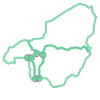

In [64]:
g_jc = geometry.MultiPoint(jo['junctions'])
g_ls = geometry.MultiLineString([obj[~np.isnan(obj)[:,0]].tolist() for obj in jo['linestrings']])
geometry.GeometryCollection([g_jc,g_ls])

In [65]:
combs = select_unique_combs(ex['linestrings'])

In [66]:
# make numpy array from coordinates of extracted linestrings
arraylist = [np.array(g) for g in ex["linestrings"]]
# lengths of linestrings
length_geoms = np.array([len(xy) for xy in arraylist])
# currently fixed to solely 2D-coordinates
no_dims = 2

# define empty array with size no. linestrings * max. length linestrings * no. coordinates
coord_arr = np.ones((len(arraylist), np.max(length_geoms), no_dims)) * np.nan
# populate columns
for i, c in enumerate(arraylist):
    coord_arr[i, : len(c)] = c

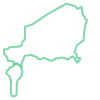

In [67]:
geometry.MultiLineString([ex["linestrings"][0], ex["linestrings"][2]]) #, ex["linestrings"][1]

In [68]:
shared_geoms = [0,2]
idx_geom = [0]

In [69]:
# get geoms that are rings
first_xy_rows = coord_arr[shared_geoms,0]
last_xy_rows = coord_arr[:,length_geoms-1][shared_geoms]
last_xy_rows = last_xy_rows.diagonal(axis1=0, axis2=1).T
rows_ring = (np.count_nonzero((first_xy_rows == last_xy_rows), axis=1) == no_dims).nonzero()[0]

# for geoms that are rings, set first coord to np.nan
# since its equal to the last coord of rings
#coord_arr[:,0][rows_ring] = np.nan

In [70]:
# create boolean of shared coords for each geom
slice_array = np.count_nonzero(
    np.isclose(coord_arr[shared_geoms], coord_arr[idx_geom], atol), 
    axis=2) == no_dims

In [71]:
slice_array

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]])

In [40]:
# for geoms that are rings, set first coord to np.nan
# since its equal to the last coord of rings
slice_array[rows_ring,0] = False

In [41]:
d = np.diff(slice_array)
row, col, = d.nonzero()
row = row.astype(float)
col = col.astype(float)

In [42]:
# for rings we compare the 2nd coord (ix 1) with the last coord
rings_start_shared = slice_array[:, 1]
rings_end_shared = slice_array[:,length_geoms-1]
rings_end_shared = rings_end_shared.diagonal(axis1=0, axis2=1).T
rings_start_end_shared = (rings_end_shared * rings_start_shared).nonzero()[0]

In [43]:
col += 1

# prepend a 0 for slice_array where start is True
rows_first_true = np.isin(row, slice_array[:, 0].nonzero()[0])
left_side_idx = np.unique(np.searchsorted(row, row, side="left"))
insert_idx_left = left_side_idx[rows_first_true[left_side_idx]]

row = np.insert(row, insert_idx_left, row[insert_idx_left])
col = np.insert(col, insert_idx_left, 0)

# append length of max-1 for end of slice_array is True
rows_last_true = np.isin(row, slice_array[:, -1].nonzero()[0])
right_side_idx = np.unique(np.searchsorted(row, row, side="right"))
insert_idx_right = right_side_idx[rows_last_true[right_side_idx - 1]]

row = np.insert(row, insert_idx_right, row[insert_idx_right - 1])
col = np.insert(col, insert_idx_right, np.max(length_geoms) - 1)

# from each segment subtract 1 from end idx, so we can slice in once
col[1::2] -= 1

In [44]:
# index of first element of each subsequence
first_idx_first_segment_row = np.nonzero(np.r_[1, np.diff(row)[:-1]])[0]
second_idx_last_segment_row = np.nonzero(np.r_[1, np.diff(row[::-1])[:-1]])[0]
second_idx_last_segment_row = np.sort(((len(row)-1) - second_idx_last_segment_row))

# if shared path pass 0-index, set first and last junction to nan, 
# first idx of first segment to nan of shared paths passing 0-index
row_bool = np.full(row.shape, False, dtype=bool)
row_bool[first_idx_first_segment_row] = True
first_idx_to_nan = row_bool * (row == rings_start_end_shared)

row[first_idx_to_nan] = np.nan
col[first_idx_to_nan] = np.nan

# last idx of last segment to nan of shared paths passing 0-index
row_bool = np.full(row.shape, False, dtype=bool)
row_bool[second_idx_last_segment_row] = True
last_idx_to_nan = row_bool * (row == rings_start_end_shared)

row[last_idx_to_nan] = np.nan
col[last_idx_to_nan] = np.nan

In [45]:
# calculate exact index of junctions for take function
col_idx = np.array((col * 2, col * 2 + 1)).T
row_idx = row * (np.max(length_geoms)) * 2
take_idx = col_idx + row_idx[None].T
take_idx = take_idx[~np.isnan(take_idx).any(axis=1)].astype(int)

In [46]:
take_idx

array([], shape=(0, 2), dtype=int64)

In [47]:
junctions = np.unique(coord_arr[shared_geoms].take(take_idx), axis=0)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [25]:
junctions

array([[ 0.89956302, 10.99733938],
       [ 2.1544735 , 11.94015005]])

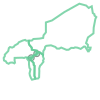

In [26]:
g_jc = geometry.MultiPoint(junctions)#jo['junctions'])
g_ls = geometry.MultiLineString([obj[~np.isnan(obj)[:,0]].tolist() for obj in coord_arr])#jo['linestrings']])
geometry.GeometryCollection([g_jc,g_ls])

In [ ]:
# where geoms are rings and first and last coordinate are shared
# remove the junction in the end of the geom so a shared-path
# crossing the zero-index is preserved

# get geoms that are rings
first_xy_rows = coord_arr[:,0,:]
last_xy_rows = coord_arr[:,length_geoms-1,:]
last_xy_rows = last_xy_rows.diagonal(axis1=0, axis2=1).T
rows_ring = ((first_xy_rows == last_xy_rows).sum(axis=1) == 2).nonzero()[0]

# get rows where first and last coords are shared
rows_start_shared = slice_array[:, 0].nonzero()[0]
rows_end_shared = slice_array[range(slice_array.shape[0]), length_geoms - 1].nonzero()[0]

# get rings where first and last coords are shared
rings_start_shared = rows_start_shared[np.isin(rows_start_shared, rows_ring)]
rings_end_shared = rows_end_shared[np.isin(rows_end_shared, rows_ring)]
rings_start_end_shared = rows_end_shared[rows_end_shared == rings_start_shared]

# set last coord of rings to False where first and last coord is shared
length_geoms2 = length_geoms.copy()
length_geoms2[length_geoms == length_geoms.max()] -= 1
length_geoms2 = length_geoms2[rings_start_end_shared]
diag_to_false = d[rings_start_end_shared[None].T,length_geoms2 - 1]

np.fill_diagonal(diag_to_false, False)
d[rings_start_end_shared[None].T,length_geoms2 - 1] = diag_to_false

row, col, = d.nonzero()
#row, col

In [ ]:
col += 1
# geoms were last coordinates end with True should not get +1, do -1
rows_xy_end_true = np.isin(row, rows_end_shared)
col[rows_xy_end_true] -= 1
#col

In [ ]:
col[1::2] -= 1
#col

In [ ]:
# calculate exact index of junctions for take function
col_idx = np.array((col * 2, col * 2 + 1)).T
row_idx = row * (np.max(length_geoms)) * 2
take_idx = col_idx + row_idx[None].T
#take_idx

In [ ]:
#coord_arr.take(take_idx)

In [ ]:
junctions = np.unique(coord_arr.take(take_idx), axis=0)
junctions = junctions[np.isin(junctions, coord_arr[idx_geom])[:,0]]

In [ ]:
# col += 1
# # geoms were last coordinates end with True should not get +1, do -1
# rows_xy_end_true = np.isin(row, rows_end_shared)
# col[rows_xy_end_true] -= 1


# # prepend a 0 for slice_array where start is True
# rows_first_true = np.isin(row, slice_array[:, 0].nonzero()[0])
# left_side_idx = np.unique(np.searchsorted(row, row, side="left"))
# insert_idx_left = left_side_idx[rows_first_true[left_side_idx]]

# row = np.insert(row, insert_idx_left, row[insert_idx_left])
# col = np.insert(col, insert_idx_left, 0)

# # append length of max-1 for end of slice_array is True
# rows_last_true = np.isin(row, slice_array[:, -1].nonzero()[0])
# right_side_idx = np.unique(np.searchsorted(row, row, side="right"))
# insert_idx_right = right_side_idx[rows_last_true[right_side_idx - 1]]

# row = np.insert(row, insert_idx_right, row[insert_idx_right - 1])
# col = np.insert(col, insert_idx_right, np.max(length_geoms) - 1)
# #col[1::2] -= 1

# # calculate exact index of junctions for take function
# col_idx = np.array((col * 2, col * 2 + 1)).T
# row_idx = row * (np.max(length_geoms)) * 2
# take_idx = col_idx + row_idx[None].T

In [ ]:
# junctions = np.unique(coord_arr.take(take_idx), axis=0)
# #np.unique(junctions, axis=0)

In [ ]:
# jo = topojson.join(ex)

In [ ]:
# jc = junctions#jo['junctions']

In [ ]:
g_jc = geometry.MultiPoint(junctions)#jo['junctions'])
g_ls = geometry.MultiLineString([obj[~np.isnan(obj)[:,0]].tolist() for obj in coord_arr])#jo['linestrings']])
geometry.GeometryCollection([g_jc,g_ls])

In [ ]:
# in idx_geom 0 is still 1 mistake. 

In [ ]:
geometry.GeometryCollection([g_jc,g_ls])

In [ ]:
np.isin(ls_xy, jc).sum(axis=2)

In [ ]:
ls_xy = jo['linestrings']
ls_xy_roll = np.roll(ls_xy, 1, axis=1)

In [ ]:
eucl_dist = np.sqrt(
    (ls_xy_roll[:, :, 0] - ls_xy[:, :, 0]) ** 2 + (ls_xy_roll[:, :, 1] - ls_xy[:, :, 1]) ** 2
)
eucl_dist[:,0] = 0
ls_cumsum = eucl_dist.cumsum(axis=0)

In [ ]:
# make numpy array from coordinates of extracted linestrings
arraylist = [np.array(g) for g in ex['linestrings']]
# lengths of linestrings
length_geoms = np.array([len(xy) for xy in arraylist])

In [ ]:
# define empty array with size no. linestrings * max. length linestrings * no. coordinates
coord_arr = np.ones((len(arraylist), np.max(length_geoms), 2))*np.nan 
# populate columns
for i, c in enumerate(arraylist):  
    coord_arr[i, :len(c)] = c

In [ ]:
junctions_list = []
for val in combs:
    idx_geom = val[0]
    shared_geoms = val[1]
    junctions = junctions_shared_paths(coord_arr, idx_geom, shared_geoms, length_geoms)
    junctions_list.extend([junctions])
    
#unique_junctions = np.unique(np.array(junctions_list), axis=0)    

In [ ]:
unique_junctions

In [ ]:
length_geom2 = np.array([len(xy) for xy in junctions_list])
len(junctions_list)
coord_ar2 = np.ones((len(junctions_list), np.max(length_geom2), 2))*np.nan 
# populate columns
for i, c in enumerate(junctions_list):  
    coord_ar2[i, :len(c)] = c

In [ ]:
coord_ar2

In [ ]:
np.unique(coord_ar2, )